# Titanic: Machine Learning from Disaster

## Competition Description

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

### Practice Skills

 * Binary classification
 * Python basics

The Titanic Kaggle competition can be found [at this link](https://www.kaggle.com/c/titanic/overview).

 - [Exploratory data analysis](#Exploratory-data-analysis)
   - [Pair plots](#Pair-plots)
 - [Looking for correlations](#Looking-for-correlations)
 - [Model pipeline](#Model-pipeline)
   - [Mean squared error](#Mean-squared-error)
   - [Confusion matrix](#Confusion-matrix)
   - [Precision, recall, F-measure and support](#Precision,-recall,-F-measure-and-support)
   - [ROC curve](#ROC-curve)
   - [Cross validation](#Cross-validation)
 - [Grid search](#Grid-search)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [3]:
train_df = pd.read_csv('data/train.csv', na_values='NaN', index_col='PassengerId')
test_df = pd.read_csv('data/test.csv', na_values='NaN', index_col='PassengerId')

In [4]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
train_df.index.nunique() == train_df.shape[0]

True

In [7]:
test_df.index.nunique() == test_df.shape[0]

True

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [10]:
train_df.nunique().sort_values(ascending=False)

Name        891
Ticket      681
Fare        248
Cabin       147
Age         88 
Parch       7  
SibSp       7  
Embarked    3  
Pclass      3  
Sex         2  
Survived    2  
dtype: int64

In [11]:
test_df.nunique().sort_values(ascending=False)

Name        418
Ticket      363
Fare        169
Age         79 
Cabin       76 
Parch       8  
SibSp       7  
Embarked    3  
Pclass      3  
Sex         2  
dtype: int64

# Exploratory data analysis

In [12]:
missing_train_sr = train_df.isnull().sum()/train_df.shape[0]*100
missing_train_sr.sort_values(ascending=False, inplace=True)
missing_train_sr = missing_train_sr[missing_train_sr.values > 0]

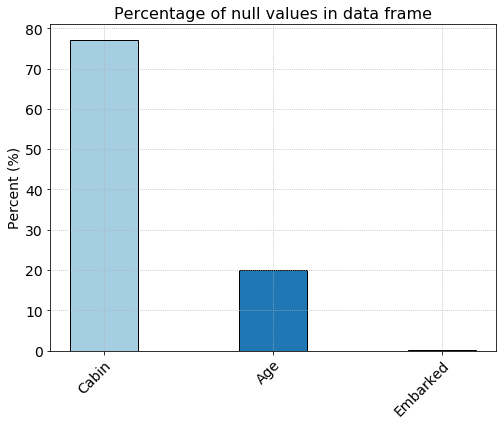

In [13]:
fig, axes = plt.subplots(figsize=(8, 6))
axes.bar(missing_train_sr.index, missing_train_sr.values, color=plt.cm.Paired.colors, edgecolor='k', width=0.4)
plt.setp(axes.get_xticklabels(), ha='right', rotation_mode='anchor', rotation=45, fontsize=14)
plt.setp(axes.get_yticklabels(), fontsize=14)
axes.set_ylabel('Percent (%)', fontsize=14)
axes.set_title('Percentage of null values in data frame', fontsize=16)
plt.grid(True, linestyle=':');

In [14]:
missing_test_sr = test_df.isnull().sum()/test_df.shape[0]*100
missing_test_sr.sort_values(ascending=False, inplace=True)
missing_test_sr = missing_test_sr[missing_test_sr.values > 0]

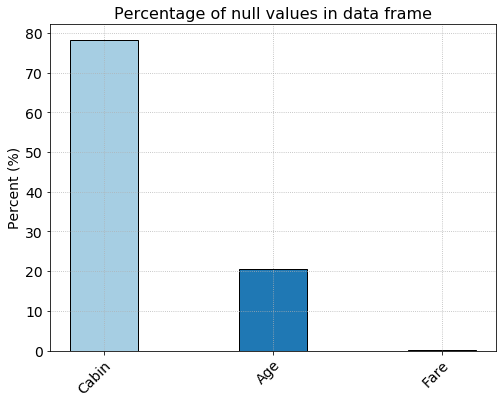

In [15]:
fig, axes = plt.subplots(figsize=(8, 6))
axes.bar(missing_test_sr.index, missing_test_sr.values, color=plt.cm.Paired.colors, edgecolor='k', width=0.4)
plt.setp(axes.get_xticklabels(), ha='right', rotation_mode='anchor', rotation=45, fontsize=14)
plt.setp(axes.get_yticklabels(), fontsize=14)
axes.set_ylabel('Percent (%)', fontsize=14)
axes.set_title('Percentage of null values in data frame', fontsize=16)
plt.grid(True, linestyle=':');

In [16]:
train_df.shape

(891, 11)

In [17]:
test_df.shape

(418, 10)

In [18]:
train_df.drop(['Cabin'], axis=1, inplace=True)
test_df.drop(['Cabin'], axis=1, inplace=True)

In [19]:
train_df[pd.isna(train_df['Embarked'])]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


In [20]:
test_df[pd.isna(test_df['Fare'])]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S


In [21]:
train_df = train_df[~pd.isna(train_df['Embarked'])]
test_df = test_df[~pd.isna(test_df['Fare'])]

In [22]:
train_df.shape

(889, 10)

In [23]:
test_df.shape

(417, 9)

In [24]:
train_df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked'],
      dtype='object')

In [25]:
test_df.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Embarked'],
      dtype='object')

In [26]:
set(train_df.columns) - set(test_df.columns)

{'Survived'}

## Pair plots

In [27]:
import warnings
warnings.filterwarnings('ignore')

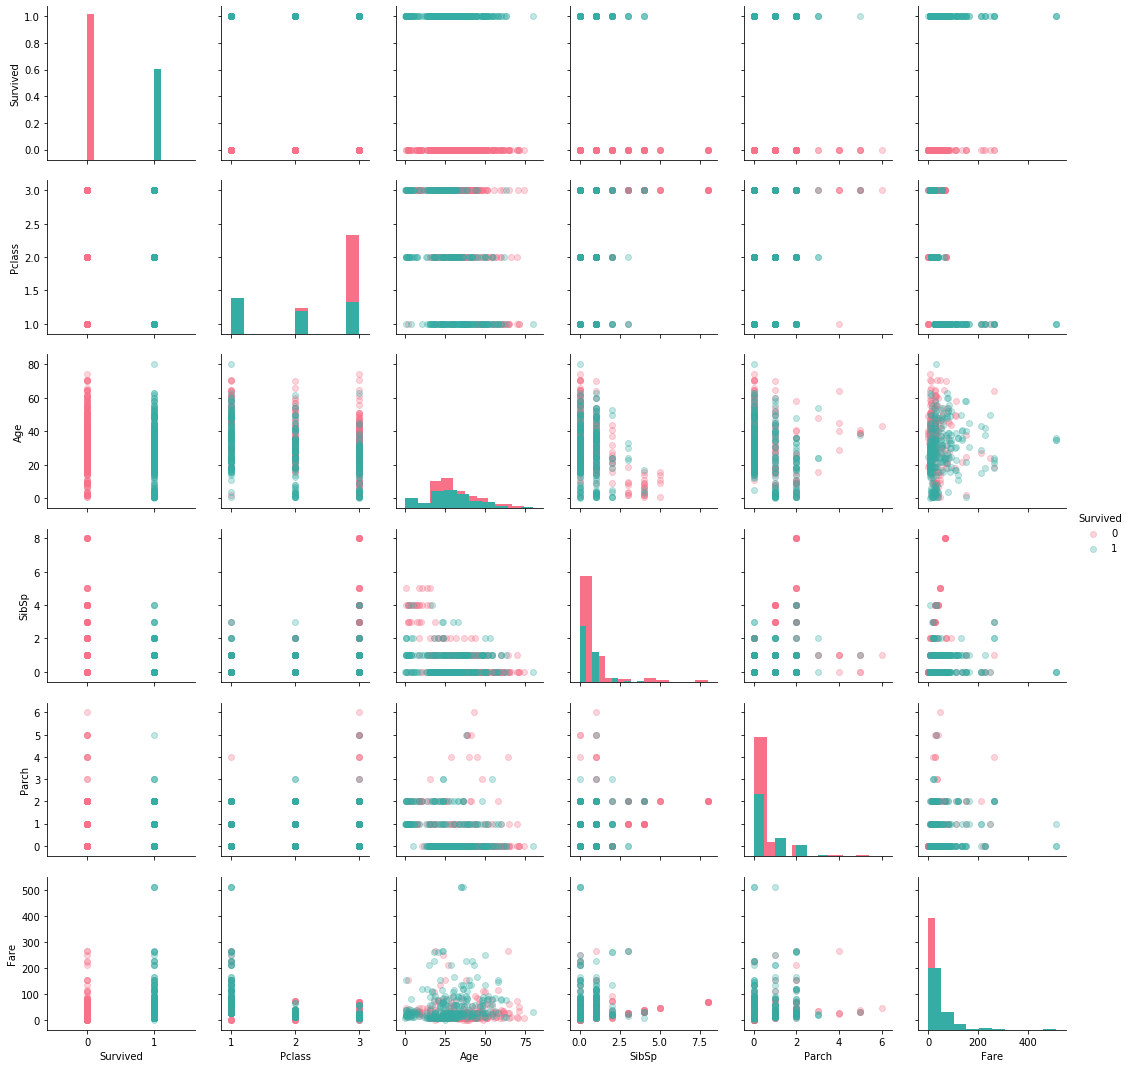

In [28]:
g = sns.PairGrid(data=train_df, hue='Survived', palette='husl')
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter, alpha=0.3)
g = g.add_legend();

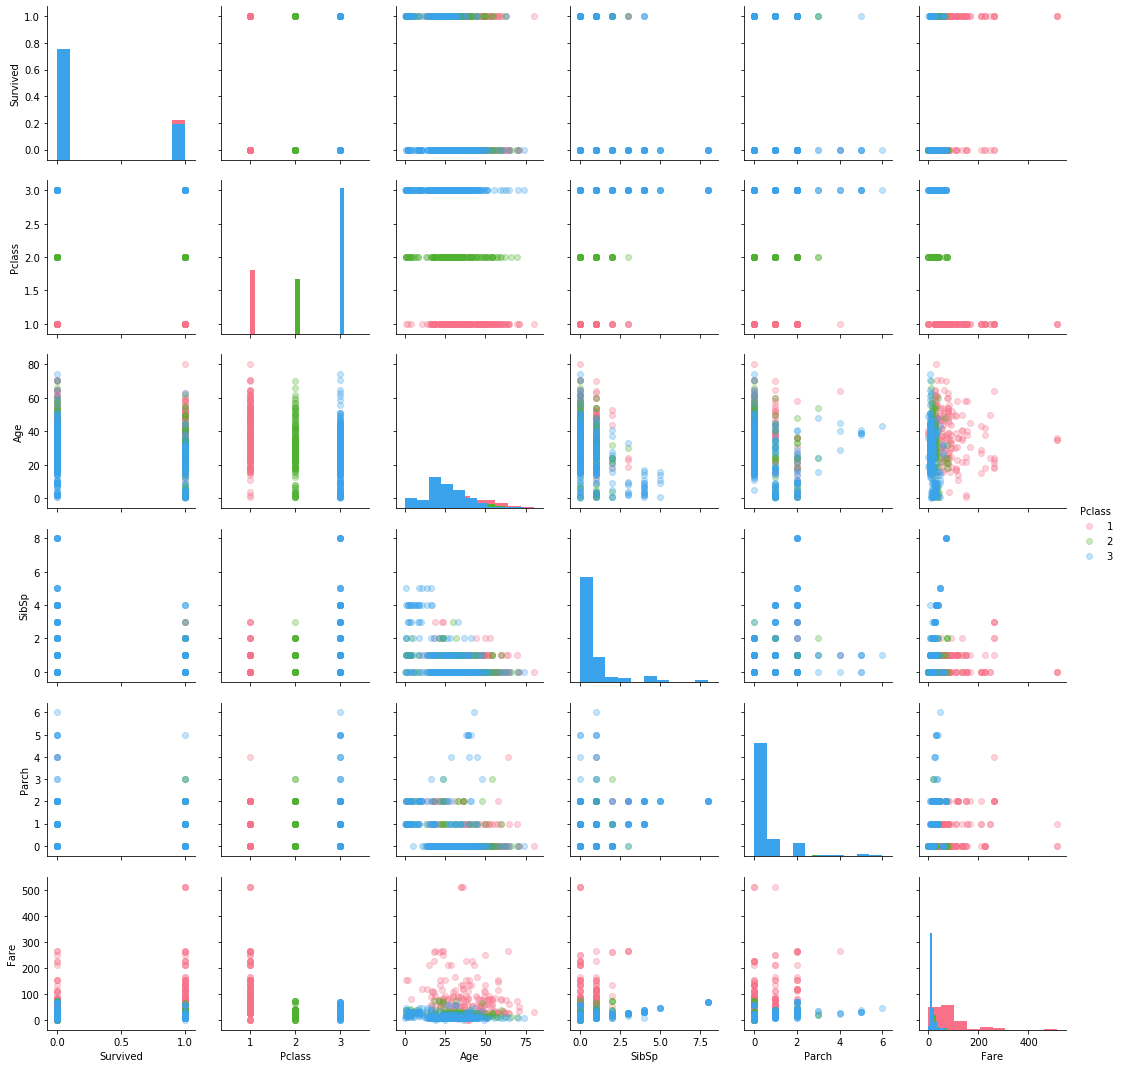

In [29]:
g = sns.PairGrid(data=train_df, hue='Pclass', palette='husl')
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter, alpha=0.3)
g = g.add_legend();

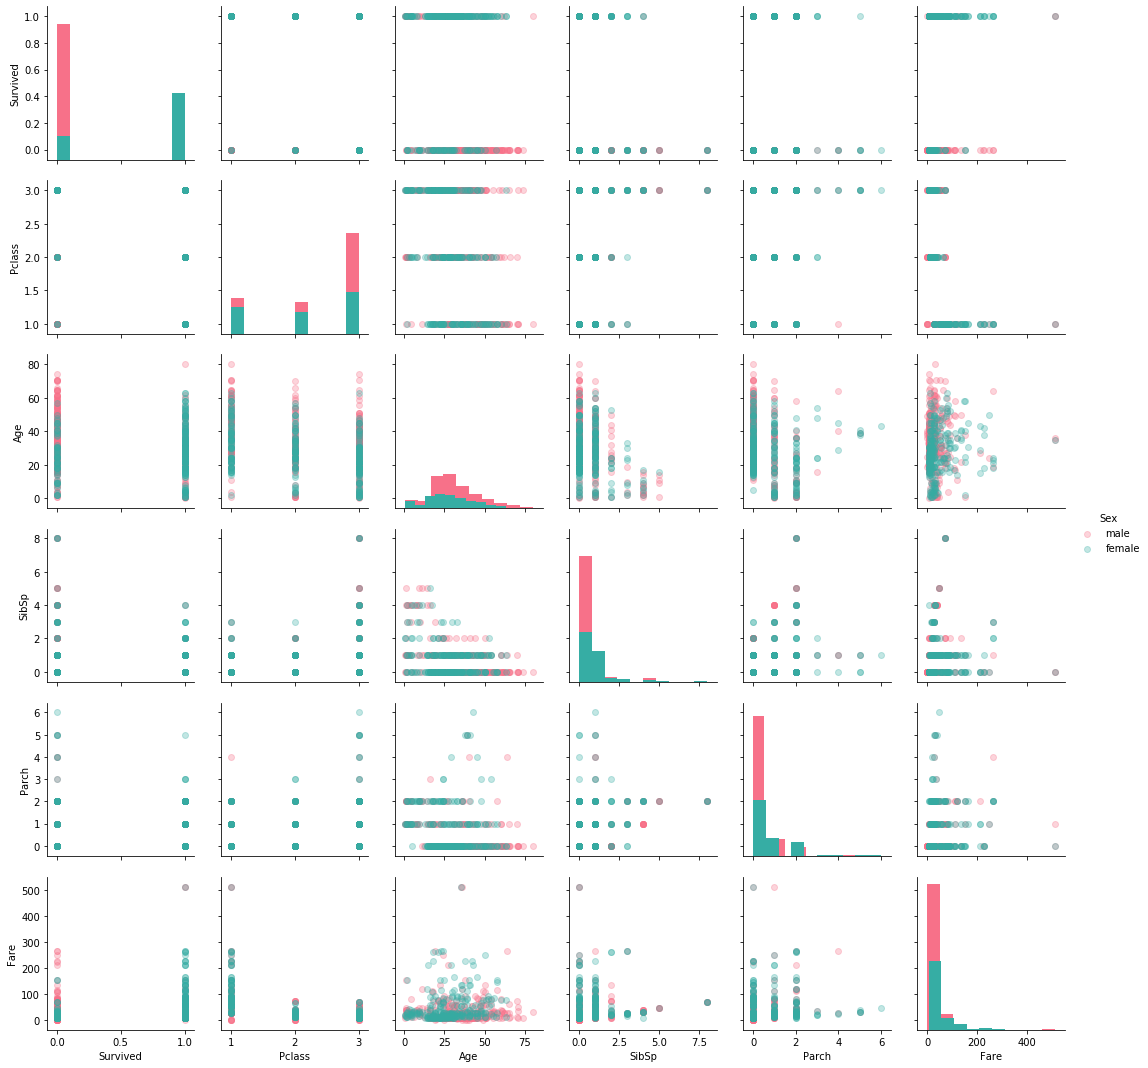

In [30]:
g = sns.PairGrid(data=train_df, hue='Sex', palette='husl')
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter, alpha=0.3)
g = g.add_legend();

# Looking for correlations

In [31]:
corr_matrix = train_df.corr()
corr_matrix['Survived'].sort_values(ascending=False)

Survived    1.000000
Fare        0.255290
Parch       0.083151
SibSp      -0.034040
Age        -0.082446
Pclass     -0.335549
Name: Survived, dtype: float64

# Model pipeline

In [32]:
cat_attrib = list(train_df.select_dtypes('object'))
num_attrib = list(set(train_df.columns) - set(cat_attrib) - set(['Survived']))

In [33]:
print(cat_attrib)
print(num_attrib)

['Name', 'Sex', 'Ticket', 'Embarked']
['Age', 'Parch', 'Pclass', 'Fare', 'SibSp']


In [34]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
imputer = SimpleImputer(strategy='median')

In [35]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('std_scaler', StandardScaler())])

In [36]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [37]:
full_pipeline = ColumnTransformer([('num', num_pipeline, num_attrib), ('cat', OneHotEncoder(), cat_attrib)])

I'm using the full `train_df` training set to create a sub-training data set and a validation (or development) set to build my model against.

In [38]:
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

In [39]:
X_prepared = full_pipeline.fit_transform(X)

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size = 0.3, random_state=42)

In [41]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')

X_train.shape: (622, 1579)
y_train.shape: (622,)


In [42]:
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_test.shape: (267, 1579)
y_test.shape: (267,)


## Training a binary classifier

In [43]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [44]:
model_dict = {'Logistic regression': LogisticRegression(solver='newton-cg', n_jobs=-1, random_state=42), \
              'Stochastic gradient descent classifier': SGDClassifier(loss='log', random_state=42), \
              'Decision tree classifier': DecisionTreeClassifier(random_state=42), \
              'Random forest classifier': RandomForestClassifier(n_jobs=-1, n_estimators=100, random_state=42), \
              'Support vector classifier': SVC(kernel='linear', gamma='scale', probability=True, random_state=42)}

In [45]:
import joblib
from time import time
t0 = time()
y_pred_results = []
y_pred_proba_results = []
for name, model in model_dict.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_results.append(y_pred)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_results.append(y_pred_proba)
    joblib.dump(model, '1-'+'_'.join(name.lower().split(' '))+'.pkl')
    print(f'Accuracy of the {name.lower()} on test set: {model.score(X_test, y_test):.4f}')
print(f'Time elapsed: {(time() - t0):.2f} seconds')

Accuracy of the logistic regression on test set: 0.8090
Accuracy of the stochastic gradient descent classifier on test set: 0.8015
Accuracy of the decision tree classifier on test set: 0.8052
Accuracy of the random forest classifier on test set: 0.8090
Accuracy of the support vector classifier on test set: 0.8127
Time elapsed: 1.52 seconds


### Mean squared error

In [46]:
from sklearn.metrics import mean_squared_error
for (name, model), y_pred in zip(model_dict.items(), y_pred_results):
    mse = mean_squared_error(y_test, y_pred)
    print(f'Root mean square error for the {name.lower():s} model: {np.sqrt(mse):.3f}')

Root mean square error for the logistic regression model: 0.437
Root mean square error for the stochastic gradient descent classifier model: 0.446
Root mean square error for the decision tree classifier model: 0.441
Root mean square error for the random forest classifier model: 0.437
Root mean square error for the support vector classifier model: 0.433


### Confusion matrix

In [47]:
from sklearn.metrics import confusion_matrix
for (name, model), y_pred in zip(model_dict.items(), y_pred_results):
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion matrix for the {name.lower()} model: \n{cm}\n')

Confusion matrix for the logistic regression model: 
[[143  24]
 [ 27  73]]

Confusion matrix for the stochastic gradient descent classifier model: 
[[141  26]
 [ 27  73]]

Confusion matrix for the decision tree classifier model: 
[[141  26]
 [ 26  74]]

Confusion matrix for the random forest classifier model: 
[[149  18]
 [ 33  67]]

Confusion matrix for the support vector classifier model: 
[[143  24]
 [ 26  74]]



### Precision, recall, F-measure and support

In [48]:
from sklearn.metrics import classification_report
for (name, model), y_pred in zip(model_dict.items(), y_pred_results):
    class_report = classification_report(y_test, y_pred)
    print(f'Precision, recall, F-measure and support for the {name.lower()} model: \n{class_report}\n')

Precision, recall, F-measure and support for the logistic regression model: 
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       167
           1       0.75      0.73      0.74       100

    accuracy                           0.81       267
   macro avg       0.80      0.79      0.79       267
weighted avg       0.81      0.81      0.81       267


Precision, recall, F-measure and support for the stochastic gradient descent classifier model: 
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       167
           1       0.74      0.73      0.73       100

    accuracy                           0.80       267
   macro avg       0.79      0.79      0.79       267
weighted avg       0.80      0.80      0.80       267


Precision, recall, F-measure and support for the decision tree classifier model: 
              precision    recall  f1-score   support

           0       0.84      0.84 

### ROC curve

In [49]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

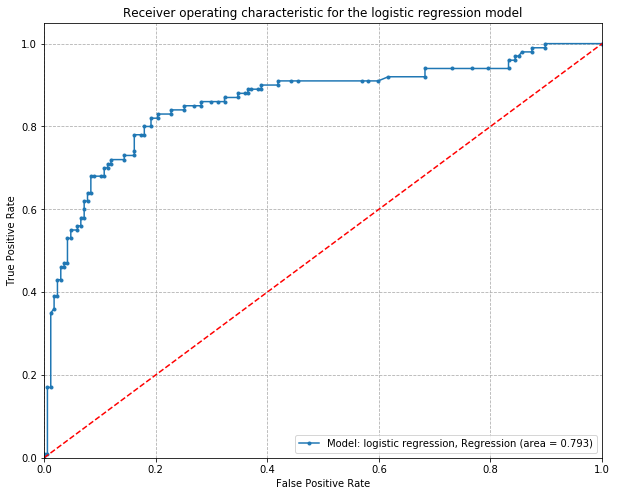

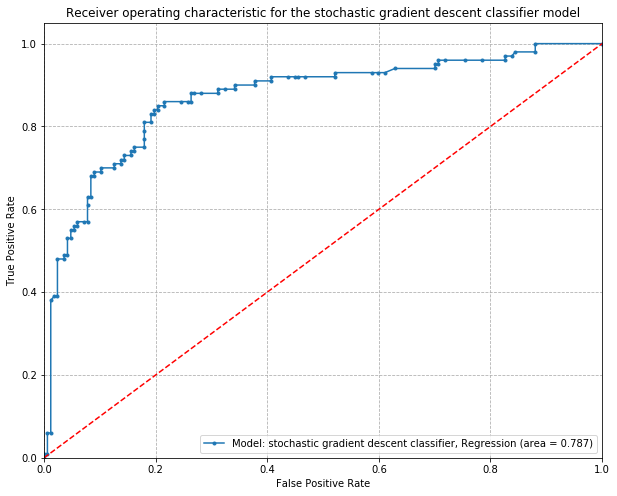

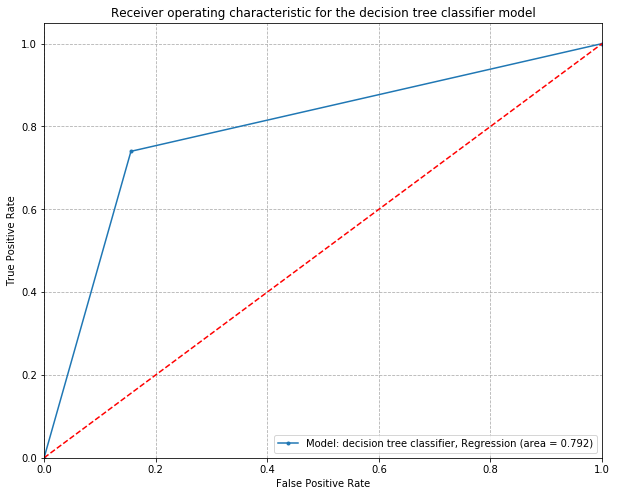

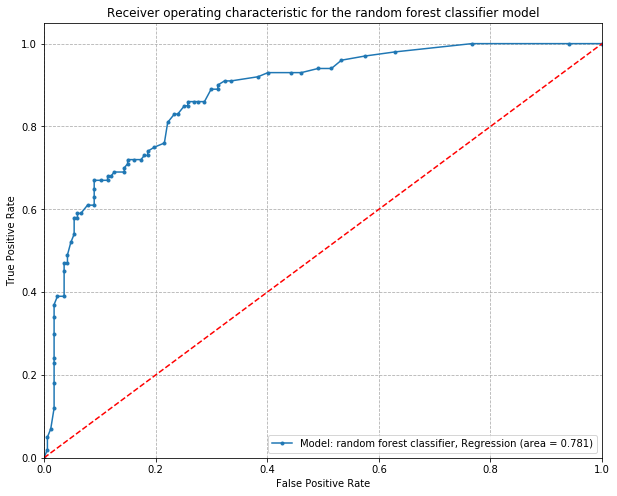

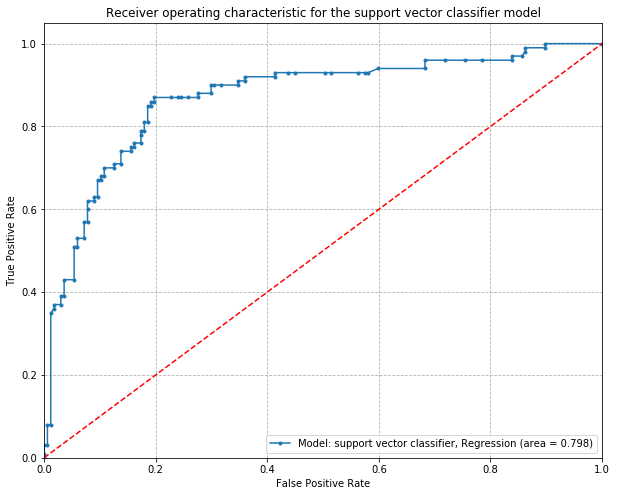

In [50]:
for (name, model), y_pred, y_pred_proba in zip(model_dict.items(), y_pred_results, y_pred_proba_results):
    model_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
#     print(f'Model: {name.title()}\nFPR: {len(fpr)}\nTPR: {len(tpr)}\nNumber of thresholds: {len(thresholds)}\n')
    fig, axes = plt.subplots(figsize=(10, 8))
    axes.plot(fpr, tpr, marker='.', ms=6, \
              label='Model: {0:s}, Regression (area = {1:.3f})'.format(name.lower(), model_roc_auc))
    axes.plot([0, 1], [0, 1],'r--')
    axes.set_xlim([0.0, 1.0])
    axes.set_ylim([0.0, 1.05])
    axes.set_xlabel('False Positive Rate')
    axes.set_ylabel('True Positive Rate')
    axes.set_title('Receiver operating characteristic for the {0:s} model'.format(name.lower()))
    axes.legend(loc="lower right")
    plt.grid(True, linestyle='--');

### Cross validation

In [51]:
from sklearn.model_selection import cross_val_score
def display_scores(model, scores):
    print(f'Cross validation for the {model.lower()} model:')
    print(f'Mean: {scores.mean():.4f}')
    print(f'Standard devation: {scores.std():.4f}\n')

In [52]:
from time import time
t0 = time()
for (name, model), y_pred in zip(model_dict.items(), y_pred_results):
    scores = cross_val_score(model, y_pred.reshape(-1, 1), y_test, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
    display_scores(name, -scores)
print(f'Time elapsed: {(time() - t0):.2f} seconds')

Cross validation for the logistic regression model:
Mean: 0.1910
Standard devation: 0.0716

Cross validation for the stochastic gradient descent classifier model:
Mean: 0.2821
Standard devation: 0.1186

Cross validation for the decision tree classifier model:
Mean: 0.1940
Standard devation: 0.0833

Cross validation for the random forest classifier model:
Mean: 0.1912
Standard devation: 0.0872

Cross validation for the support vector classifier model:
Mean: 0.1873
Standard devation: 0.0870

Time elapsed: 1.83 seconds


# Grid search

I'm going to try a grid search optimization using the random forest classifier model.

In [53]:
from sklearn.model_selection import GridSearchCV

In [54]:
param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, \
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}]

In [55]:
rf_clf = RandomForestClassifier()
grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring='neg_mean_squared_error', \
                           return_train_score=True, iid=False)
grid_search.fit(X_train, y_train)
joblib.dump(grid_search, '1-rf_grid_search.pkl')
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [56]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(f'RMSE: {np.sqrt(-mean_score):.5f}, Parameters: {params}')

RMSE: 0.49273, Parameters: {'max_features': 2, 'n_estimators': 3}
RMSE: 0.43377, Parameters: {'max_features': 2, 'n_estimators': 10}
RMSE: 0.41862, Parameters: {'max_features': 2, 'n_estimators': 30}
RMSE: 0.50238, Parameters: {'max_features': 4, 'n_estimators': 3}
RMSE: 0.43744, Parameters: {'max_features': 4, 'n_estimators': 10}
RMSE: 0.42440, Parameters: {'max_features': 4, 'n_estimators': 30}
RMSE: 0.48610, Parameters: {'max_features': 6, 'n_estimators': 3}
RMSE: 0.43738, Parameters: {'max_features': 6, 'n_estimators': 10}
RMSE: 0.39078, Parameters: {'max_features': 6, 'n_estimators': 30}
RMSE: 0.48280, Parameters: {'max_features': 8, 'n_estimators': 3}
RMSE: 0.42627, Parameters: {'max_features': 8, 'n_estimators': 10}
RMSE: 0.42625, Parameters: {'max_features': 8, 'n_estimators': 30}
RMSE: 0.47621, Parameters: {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
RMSE: 0.42239, Parameters: {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
RMSE: 0.44473, Parameters: 